# Manual Regard on Elastic Roll Flattening with Hitchcock's Approach

In [ ]:
# only for Google Colab
!wget -N "https://raw.githubusercontent.com/Institute-of-Metal-Forming/notebooks-ilsenburg/refs/heads/main/requirements.txt"
!wget -N "https://raw.githubusercontent.com/Institute-of-Metal-Forming/notebooks-ilsenburg/refs/heads/main/roll-flattening/Abplattung_Hitchcock.png"
!wget -N "https://raw.githubusercontent.com/Institute-of-Metal-Forming/notebooks-ilsenburg/refs/heads/main/roll-flattening/Darstellung_reale_Abplattung.png"
!wget -N "https://raw.githubusercontent.com/Institute-of-Metal-Forming/notebooks-ilsenburg/refs/heads/main/roll-flattening/Hitchcock_Ersatzspannungsverteilung.png"
!pip install -r "requirements.txt"

Import the core library and a bunch of plugins. We assign `pr` as a shortcut to the PyRolL library to save typing efforts.

In [8]:
import pandas as pd
import plotly.express as px
import numpy as np

import pyroll.basic as pr
import pyroll.export as pe

Import additional libraries and make some basic configuration.

In [2]:
import logging
import sys

logging.basicConfig(stream=sys.stdout, format="[%(levelname)s] %(name)s: %(message)s")
logging.getLogger("pyroll").setLevel(logging.INFO)

## Introduction on Roll Flattening After Hitchcock

For the former calculations, it was assumed that the radius of the working rolls is not changing. To get more accurate results, the elastic deformation of the roll, with the result of the temporary flattening of the roll in the roll gap. If the pressure distribution is known, the real flattening can be calculated numerically (Hertz'sche Pressung). A sketch of the flattening in the roll gap can be seen here:

![](Darstellung_reale_Abplattung.png)

There are certain approximations which can be taken, for example by Hitchcock, which replaced the real roll flattening curve through an elliptical pressure distribution which can be seen in the following figure on the left side and the depiction in the roll gap on the right side.

![](Hitchcock_Ersatzspannungsverteilung.png)

![](Abplattung_Hitchcock.png)

The equation by Hitchcock can be summed up by:
$$\dfrac{R'}{R_0} = 1 + C \cdot {\frac{F'_w }{b \, \Delta h}}$$
with $$C = {\dfrac{16 (1-\nu ^2)}{\pi E}}$$
with $R'$ = flattened roll radius, $R$ = unflattened roll radius, $F'_w$ = calculated roll force, $b$ = width of the work piece, $\nu$ = Poissonzahl des Walzenwerkstoffes, $E$ = E-Modul des Walzenwerkstoffes

Bohm, Flaxa and Hinkfoth extend this equation for ${R'}/{R_0} > 5.235$ relationships, therefore mainly for the cold rolling of thin strips and replaced the right side of the equation with:
$$ 2 \cdot \left(C \cdot {\frac{F'_w }{b \, \Delta h}} \right)^{2/3}$$

We use the values for rolls made of hardened steel: $E = 210 \, GPa$ and $\nu = 0.3$


In [3]:
def flattening_hitchcock(
    roll_force_current: float, delta_height: float, width_work_piece: float
):
    youngs_modulus = 210e9
    poisson_ratio = 0.3
    c = 16 * (1 - poisson_ratio**2) / (np.pi * youngs_modulus)
    flattening_factor = c * roll_force_current / (width_work_piece * delta_height)
    if flattening_factor < 4.235:
        ratio = 1 + flattening_factor
    else:
        ratio = 2 * flattening_factor ** (2 / 3)
    print(ratio)
    return ratio


def flattened_radius(
    radius_starting: float,
    roll_force_current: float,
    delta_height: float,
    width_work_piece: float,
):
    ratio = flattening_hitchcock(roll_force_current, delta_height, width_work_piece)
    return radius_starting * ratio

## Definition of the Rolling Process Using PyRolL

We define an initial workpiece.

In [4]:
in_profile = pr.Profile.box(
    height=4e-3,
    width=50e-3,
    corner_radius=0,
    temperature=25 + 273.15,
    strain=0,
    material="C45",
    density=7.5e3,
    specific_heat_capacity=690,
)
in_profile

BoxProfile(
    classifiers={'box'},
    corner_radius=0,
    cross_section=Polygon(
        area=0.0002,
        height=0.004,
        perimeter=0.10800000000000001,
        width=0.05,
        ),
    density=7500.0,
    material='C45',
    specific_heat_capacity=690,
    strain=0,
    t=0,
    temperature=298.15,
    )

The roll pass is given by a factory function that has the *current flattened* roll radius as parameter. 

In [5]:
def roll_pass(roll_radius):
    return pr.RollPass(
        label="Flach Sack I",
        roll=pr.Roll(
            groove=pr.FlatGroove(
                usable_width=250e-3,
            ),
            nominal_radius=roll_radius,
        ),
        gap=2e-3,
        velocity=0.1,
        coulomb_friction_coefficient=0.2,
    )

## Running the Iteration

First, we define a data frame to store the results in. We already insert the initial (nominal) roll radius.

In [9]:
df = pd.DataFrame({"roll_radius": 150e-3}, index=[0])
df

,roll_radius
0,0.15


Then we iterate several times simulation the roll pass over and over again while updating the roll radius according to Hitchcock's approach.

In [10]:
for i in range(10):
    rp = roll_pass(df["roll_radius"][i])
    rp.solve(in_profile)
    df.loc[i, "roll_force"] = rp.roll_force
    df.loc[i, "contact_length"] = rp.roll.contact_length
    df.loc[i + 1, "roll_radius"] = flattened_radius(df["roll_radius"][0], rp.roll_force, -rp.abs_draught, rp.in_profile.width)
    

[INFO] pyroll.core.Unit: Started solving of TwoRollPass 'Flach Sack I'.
[INFO] pyroll.core.Unit: Started solving of Rotator 'Auto-Rotator for TwoRollPass 'Flach Sack I''.
[INFO] pyroll.core.Unit: Finished solving of Rotator 'Auto-Rotator for TwoRollPass 'Flach Sack I'' after 2 iterations.
[INFO] pyroll.core.Unit: Solution took 0.002 s.
[INFO] pyroll.core.Unit: Finished solving of TwoRollPass 'Flach Sack I' after 46 iterations.
[INFO] pyroll.core.Unit: Solution took 0.220 s.
1.519725489647846
[INFO] pyroll.core.Unit: Started solving of TwoRollPass 'Flach Sack I'.
[INFO] pyroll.core.Unit: Started solving of Rotator 'Auto-Rotator for TwoRollPass 'Flach Sack I''.
[INFO] pyroll.core.Unit: Finished solving of Rotator 'Auto-Rotator for TwoRollPass 'Flach Sack I'' after 2 iterations.
[INFO] pyroll.core.Unit: Solution took 0.002 s.
[INFO] pyroll.core.Unit: Finished solving of TwoRollPass 'Flach Sack I' after 52 iterations.
[INFO] pyroll.core.Unit: Solution took 0.219 s.
1.7143124229545033
[INFO

The data frame now holds the intermediate results.

In [11]:
df

,roll_radius,roll_force,contact_length
0,0.150000,2.354951e+06,0.017292
1,0.227959,3.236652e+06,0.021329
2,0.257147,3.556829e+06,0.022656
3,0.267746,3.666435e+06,0.023119
4,0.271374,3.705444e+06,0.023276
5,0.272666,3.719315e+06,0.023331
6,0.273125,3.724245e+06,0.023351
7,0.273288,3.725998e+06,0.023358
8,0.273346,3.726620e+06,0.023360
9,0.273367,3.726842e+06,0.023361


So we can investigate the convergence of the iteration.

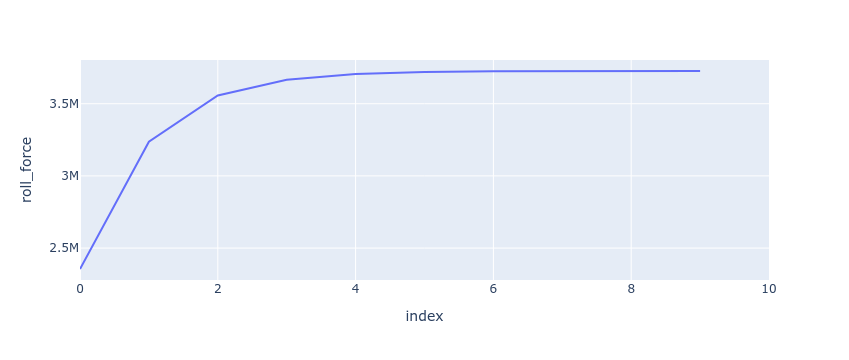

In [12]:
px.line(df, y="roll_force")

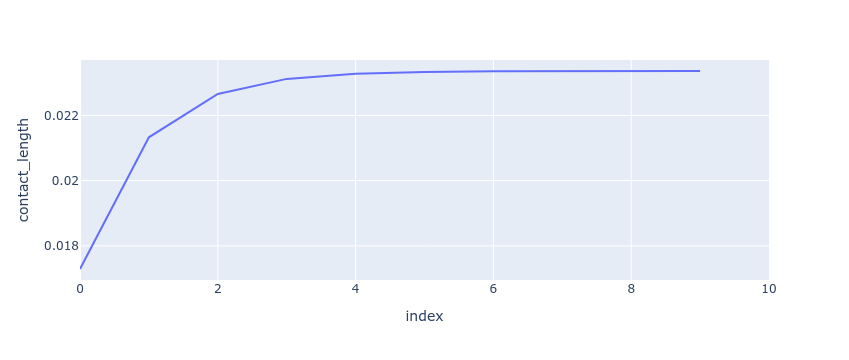

In [13]:
px.line(df, y="contact_length")

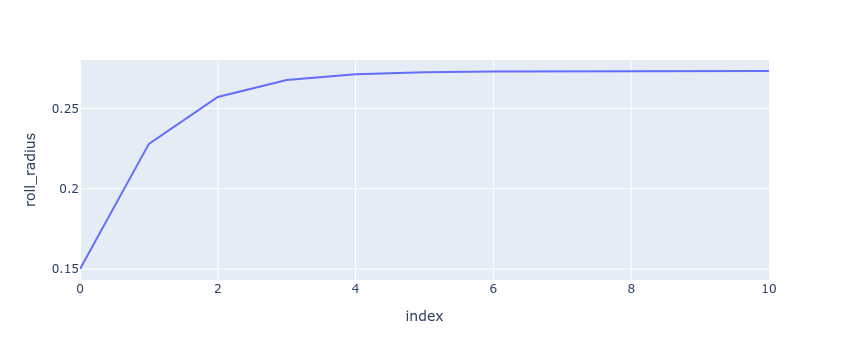

In [14]:
px.line(df, y="roll_radius")